## Random Forest

Author: Elisa Warner
Created: 4/16/2019

Purpose: Check results of SVM against stock data

Change Record:  
6/11/2019 Made Time-Cross Validation be non-overlapping  
6/13/2019 Changed Labels so they are based on de fact RUA Close, not SI. Also added Regression RF

## Confusion Table Function

In [17]:
###########################
## Create confusion table
###########################

import matplotlib
import matplotlib.pyplot as plt

def prediction_box(predictions, ground_truth):
    ## results
    result = {'tp':0, 'fp':0, 'tn':0, 'fn':0}

    for i in range(len(predictions)):
        #print(pred_test[i], y[i])
        if predictions[i] == ground_truth[i] and ground_truth[i] == 1:
            result['tp'] = result.get('tp', 0) + 1
        elif predictions[i] == ground_truth[i] and ground_truth[i] == 0:
            result['tn'] = result.get('tn', 0) + 1
        elif predictions[i] != ground_truth[i] and ground_truth[i] == 1:
            result['fn'] = result.get('fn', 0) + 1
        else:
            result['fp'] = result.get('fp', 0) + 1

    m = np.array([[result['tp'], result['fn']],[result['fp'],result['fn']]])
    fig, ax = plt.subplots()
    im = ax.imshow(m, cmap='Pastel1')
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(j, i, "{:.2f}".format(m[i,j]), ha="center", va="center")
            plt.title('Predictions for Test Set')
            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])
            ax.set_xticklabels([1, 0])
            ax.set_yticklabels([1, 0])
            plt.ylabel('Ground Truth')
            plt.xlabel('Prediction')

### Remove Missing

In [18]:
def remove_missing(df):
    for col in list(df):
        colvals = df[col].values
        new_colvals = []
        for i in range(len(colvals)):
            if colvals[i] == '.':
                print('Missing found')
                new_colvals.append(colvals[i-1])
            elif pd.isnull(colvals[i]):
                print('nan found')
                new_colvals.append(colvals[i-1])
            else:
                new_colvals.append(colvals[i])
        df[col] = new_colvals
    
    return df

In [19]:
def remove_missing_horz(df):
    new_df = pd.DataFrame()
    for i in range(df.shape[0]):
        row = list(df.iloc[i].values)

        if '.' in row:
            idx_list = [i for i in range(len(row)) if row[i] == ('.')]
            for idx in idx_list:
                row[idx] = row[idx - 1]

        idx_list = [i for i in range(len(row)) if pd.isnull(row[i]) == True]
        for idx in idx_list:
            row[idx] = row[idx - 1]
            
        new_df = new_df.append(pd.DataFrame(row).T, ignore_index = True)
    
    return new_df

## 1. Load Data

In [20]:
#!pip3 install -U scikit-learn scipy matplotlib

In [21]:
import pandas as pd
from sklearn import svm
import numpy as np

In [22]:
file1 = "./Combined_Sets_from_Revised.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
train_pd.shape

(7120, 423)

In [23]:
#train_pd[5902:7100] # Google Trends part

In [27]:
train_pd = train_pd[1:7100] #[5902:7100]

train = np.array(train_pd)
train.shape

(7099, 423)

In [28]:
train = train[:, :149] # drop google columns

In [29]:
train = train[2:,2:] # drop date
train

array([[1, 172.779999, 8.16, ..., 395.35, 398.0, 403.7],
       [1, 171.169998, 8.25, ..., 398.0, 403.7, 383.5],
       [1, 172.759995, 8.16, ..., 403.7, 383.5, 380.0],
       ...,
       [1, 1624.060059, 2.636, ..., 1308.4, 1299.2, 1302.65],
       [1, 1620.699951, 2.625, ..., 1299.2, 1302.65, 1305.35],
       [1, 1644.869995, 2.6430000000000002, ..., 1302.65, 1305.35,
        1308.35]], dtype=object)

## 2. Time-Series Cross validation

In [30]:
def time_cross(array, time_shift = 0, size_train_set = 365, size_val_set = 100, set_shift = 0):
    np.random.seed(100)
    label_idx = 0

    if time_shift == 0:
        time_shift = size_train_set + size_val_set + set_shift
        
    train_size = train.shape
    j = 0
    group = 1
    end = train_size[0]
    trainDataPartition = [] # list
    valDataPartition = []

    #print(size_train_set, size_val_set, train_size[0])
    while j + (size_train_set + size_val_set + set_shift) < train_size[0]:
        trainset = []
        valset = []

        trainset = train[j:j+size_train_set, :] # array
        valset = train[j+size_train_set+1+set_shift:j+size_train_set+size_val_set+set_shift, :]

        trainDataPartition.append(trainset)
        valDataPartition.append(valset)
    
        group = group+1;
        j = j + time_shift


    # make last set -- decide if you want to throw out or adjust this set
    print('Last set:', j, j+size_train_set)
    trainset = train[j:j+size_train_set, :]
    valset = train[j+size_train_set+1+set_shift:end, :]
    #print(trainset)
    #print(valset)
    
    trainDataPartition.append(trainset)
    valDataPartition.append(valset)

    
    ### Optional: stratify
    revised_trainDataPartition = []
    revised_valDataPartition = []
    
    for i in range(len(trainDataPartition)):
        trainset = trainDataPartition[i]
        valset = valDataPartition[i] # Do the same for validation set
        
        print(trainset.shape[0], valset.shape[0])
        records = trainset[:,0] # record of labels for training set
        records_val = valset[:, 0] # record of labels for validation set
        #print(sum(records == 1), sum(records == 0))
        #print(sum(records_val == 1), sum(records_val == 0))
        
        ############ FOR TRAINING SET ################
        if sum(records == 1) == 0 or sum(records == 0) == 0:
            revised_trainDataPartition.append(np.nan)
        elif sum(records == 1) > sum(records == 0):
            while sum(records == 1) >= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                #print(r)
                if records[r] == 1:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
            
        else:
            while sum(records == 1) <= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                if records[r] == 0:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
        #print(sum(records == 1), sum(records == 0))
        
        ############## FOR VALIDATION SET ################
        if sum(records_val == 1) == 0 or sum(records_val == 0) == 0:
            revised_valDataPartition.append(np.nan)
        elif sum(records_val == 1) > sum(records_val == 0):
            while sum(records_val == 1) >= 1.3 * sum(records_val == 0):
                r = round(np.random.rand() * (valset.shape[0]-1))
                #print(r)
                if records_val[r] == 1:
                    valset = np.delete(valset, r, 0)
                    records_val = np.delete(records_val, r)
            revised_valDataPartition.append(valset)
        else:
            while sum(records_val == 1) <= 1.3 * sum(records_val == 0):
                r = round(np.random.rand() * (valset.shape[0]-1))
                if records_val[r] == 0:
                    valset = np.delete(valset, r, 0)
                    records_val = np.delete(records_val, r)

            revised_valDataPartition.append(valset)

    group = len(revised_trainDataPartition)
    group_val = len(revised_valDataPartition)
    print('Number of groups:', group, group_val)
    
    return revised_trainDataPartition, revised_valDataPartition, group

In [31]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 260, 30)

Last set: 7000 7410
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
97 0
Number of groups: 11 11


In [32]:
t = pd.DataFrame(valDataPartition[1])
t.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,144,145,146
0,1,319.92,6.135,0.106634,0.565864,0.0800257,321.16,6.202,0.110136,0.566538,...,1,152.9,100.767,388.2,388.2,389.3,389.25,387.85,385.85,386.45
1,1,321.16,6.202,0.110136,0.566538,0.084929,318.78,6.257,0.107527,0.566251,...,1,152.9,100.767,388.2,389.3,389.25,387.85,385.85,386.45,386.65
2,1,315.46,6.407,0.105492,0.565838,0.0732053,315.8,6.494,0.105421,0.565764,...,1,152.9,100.767,387.85,385.85,386.45,386.65,385.8,386.1,383.2
3,1,315.8,6.494,0.105421,0.565764,0.0715516,317.9,6.437,0.109369,0.566258,...,1,152.9,100.767,385.85,386.45,386.65,385.8,386.1,383.2,383.35
4,1,317.9,6.437,0.109369,0.566258,0.0794667,320.43,6.411,0.11187,0.565999,...,1,152.9,100.767,386.45,386.65,385.8,386.1,383.2,383.35,381.75
5,1,322.25,6.429,0.104087,0.566161,0.0702929,320.72,6.489,0.102371,0.565813,...,1,152.9,100.767,383.35,381.75,382.65,382.75,384.35,383.75,384.35
6,1,320.14,6.472,0.101315,0.56532,0.0647332,320.97,6.455,0.106619,0.565635,...,1,152.9,100.767,384.35,383.75,384.35,384.5,384.05,383.9,383.5
7,1,320.97,6.455,0.106619,0.565635,0.0743753,321.15,6.45,0.106665,0.565317,...,1,153.1,100.532,383.75,384.35,384.5,384.05,383.9,383.5,384.5
8,1,321.15,6.45,0.106665,0.565317,0.0745866,321.06,6.476,0.106432,0.564996,...,1,153.1,100.532,384.5,384.05,383.9,383.5,384.5,384.1,383
9,1,320.07,6.513,0.105337,0.564897,0.0711763,318.93,6.586,0.104507,0.564785,...,1,153.1,100.532,383.9,383.5,384.5,384.1,383,384.85,385.55


In [33]:
#trainDataPartition[18]
t = pd.DataFrame(trainDataPartition[1])
t.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,144,145,146
0,1,268.45,5.27,0.171129,0.388682,0.304692,271.07,5.23,0.171098,0.387936,...,1,146,99.6691,366.6,365.9,365.35,365,368.85,371.6,371.55
1,0,271.07,5.23,0.171098,0.387936,0.30623,272.29,5.19,0.177139,0.38726,...,1,146,99.6691,365.9,365.35,365,368.85,371.6,371.55,370.65
2,1,272.29,5.19,0.177139,0.38726,0.323398,271.28,5.27,0.162345,0.385274,...,1,146,99.6691,365.35,365,368.85,371.6,371.55,370.65,371.5
3,0,271.28,5.27,0.162345,0.385274,0.284589,269.28,5.27,0.15968,0.387196,...,1,146,99.6691,365,368.85,371.6,371.55,370.65,371.5,368.5
4,0,269.28,5.27,0.15968,0.387196,0.276293,268.95,5.26,0.159062,0.389067,...,1,146,99.6691,368.85,371.6,371.55,370.65,371.5,368.5,368.65
5,0,268.95,5.26,0.159062,0.389067,0.273635,268.78,5.35,0.156563,0.390275,...,1,146,99.6691,371.6,371.55,370.65,371.5,368.5,368.65,369.1
6,1,268.01,5.42,0.157613,0.391404,0.264212,268.11,5.47,0.165932,0.393012,...,1,146,99.6691,370.65,371.5,368.5,368.65,369.1,369.1,367.95
7,1,268.11,5.47,0.165932,0.393012,0.283025,267.86,5.43,0.165403,0.395097,...,1,146,99.6691,371.5,368.5,368.65,369.1,369.1,367.95,362.5
8,1,269.92,5.41,0.170818,0.398341,0.293009,270.45,5.388,0.169692,0.399502,...,1,146,99.6691,369.1,369.1,367.95,362.5,363,369.1,374.4
9,1,270.45,5.388,0.169692,0.399502,0.28989,271.21,5.56,0.162783,0.39826,...,1,146,99.6691,367.95,362.5,363,369.1,374.4,377.9,376.35


## 3. Random Forest Implementation
No normalization necessary for Random Forest

In [34]:
##############################################################################
### Try Random Forest Classifier

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [35]:
def rf(train_list, val_list, group):
    splits = group
    score = []

    #kf = sklearn.model_selection.KFold(n_splits=splits, random_state = 10, shuffle = True)
    #kf.get_n_splits(features)

    data_size = trainDataPartition[0].shape

    for idx in range(len(trainDataPartition)-1):
            # print("TRAIN:", train_index, "TEST:", test_index)
            try:
                X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
                y_train = y_train.astype('int')
                #print(X_train)
                X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
                y_test = y_test.astype('int')
                print('train:', sum(y_train), len(y_train))
                print('test:', sum(y_test), len(y_test))

                # Fit the RF model
                clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0)
                clf.fit(X_train, y_train)
                
                # print predicitions
                pred = clf.predict(X_test)
                #print(pred)

            except:
                print('Skipped due to NaN')
                continue # nan
                
            # add up AUROCs            
            try:
                temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
                #temp_score = sklearn.metrics.accuracy_score(y_test,pred)
                #score = score + sklearn.metrics.accuracy_score(y_test, pred)
                #temp_score = sum([1 for i in range(len(pred)) if pred[i] == y_test[i]]) / len(pred)
                score.append(temp_score)
                print(temp_score)
            except:
                pass


    # calculate average
    score = np.mean(score)
    print("Averaged Score is: %0.4f" % score, splits)


    # print(clf.feature_importances_)
    
    return score

In [36]:
print('groups', group)
rf(valDataPartition, trainDataPartition, group)

groups 11
train: 227 402
test: 101 179
Skipped due to NaN
train: 175 310
test: 100 177
Skipped due to NaN
train: 129 229
test: 114 202
0.5069776714513556
train: 216 410
test: 125 221
0.5
train: 227 410
test: 136 241
0.5
train: 192 340
test: 89 158
0.5
train: 169 298
test: 102 181
0.5
train: 153 271
test: 96 170
0.5
train: 163 289
test: 125 221
0.51125
train: 131 232
test: 129 229
0.44593023255813946
Averaged Score is: 0.4955 11


0.4955197380011869

Hyperparameter Test

In [37]:
### Test
# time_shift, size_train_set, size_val_set

time_shift = [0] # smaller time shift is better, smaller training set, smaller val set 0, 50, 100, 126, 252, 504
# 504 252 50 0.61268998
size_train_set = [100, 252, 410]
size_val_set = [50, 100, 260] # predict a month ahead (shift labels)

score_matrix = np.zeros((len(time_shift), len(size_train_set), len(size_val_set)))
settings_matrix = np.zeros((len(size_train_set), len(size_val_set)), dtype = 'i,i')

for i in range(len(time_shift)):
    for j in range(len(size_train_set)):
        for k in range(len(size_val_set)):
            print(time_shift, size_train_set[j], size_val_set[k])
            trainDataPartition, valDataPartition, group = time_cross(train, time_shift[i], size_train_set[j], size_val_set[k], 30)

            #time_shift[i]
            try:
                score_matrix[i][j][k] = rf(valDataPartition, trainDataPartition, group)
            except:
                print('Cannot compute score')
            settings_matrix[j][k][0] = size_train_set[j]
            settings_matrix[j][k][1] = size_val_set[k]
            
print(np.argmax(score_matrix, axis = 1))
print(score_matrix)
print(settings_matrix)
#0.61268998 Didn't work so well with Label 2
# Perfomed well with predicting next day with Google Trends 0.8975, best was 0.96

[0] 100 50
Last set: 7020 7120
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
77 0
Number of groups: 40 40
train: 38 68
test: 25 49
0.54
train: 42 74
test: 24 42
0.5
train: 37 66
test: 24 42
Skipped due to NaN
train: 33 59
test: 25 49
0.42
train: 42 74
test: 7 13
0.5
Skipped due to NaN
train: 16 29
test: 11 20
Skipped due to NaN
train: 55 98
test: 3 6
Skipped due to NaN
Skipped due to NaN
Skipped due to NaN
Skipped due to NaN
train: 31 55
test: 22 38
0.7159090909090908
train: 44 78
test: 19 33
0.6033834586466165
train: 50 88
test: 22 38
0.5
train: 39 68
test: 22 38
0.9375
Skipped due to NaN
train: 53 94
test: 27 48
0.6904761904761905
train: 20 36
test: 2 4
0.25
train: 53 100
test: 24 42
0.6944444444444444
train: 38 68
test: 22 38
0.5255681818181819
train: 51 91
te

In [38]:
t = np.max(score_matrix, axis = 1)
#print(np.argmax(t, axis = 1))
t

array([[0.56735867, 0.54255084, 0.53995329]])

# Look for Feature Importances

In [45]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 252, 50, 30) #10 252 100 Draft_Google_shorter 0.8795

Last set: 6972 7224
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
252 49
125 0
Number of groups: 22 22


In [46]:
splits = group
score_list = []
indices = []
pred_labels = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
        pred_labels.append(pred)
        print(pred)
        #print(pred)
    except:
        print('Skipped')
        continue #np.nan
        
    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

train: 116 206
test: 22 38
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1
 0]
0.625
train: 110 195
test: 2 4
Skipped
train: 129 252
test: 19 34
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
0.8157894736842105
train: 28 50
test: 15 27
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.5
train: 103 183
test: 22 39
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
0.5
Skipped
train: 115 204
test: 25 49
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0]
0.73
train: 113 199
test: 2 3
[1 1 1]
0.5
train: 103 182
test: 20 36
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.5
train: 72 128
test: 22 38
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]
0.5
train: 133 252
test: 15 27
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.5
train: 111 197
test: 1 2
[1 0]
1.0
train: 124 220
test: 22 38
[

Plot the accuracy through time

Standard Deviation: 0.1543071327866283
[0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]


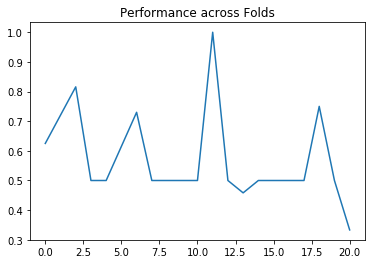

In [47]:
import matplotlib.pyplot as plt
print("Standard Deviation:", np.std(score_list))
print(indices)
plt.figure()
plt.plot(indices, score_list)
plt.title('Performance across Folds')
plt.show()

Which features are important during the time when the datasets are accurate?

In [48]:
indices = [x for x in range(len(score_list)) if score_list[x] > 0.5]
importance = np.array([])
count = 0

for idx in range(0, len(trainDataPartition)): # for several months of 2012, May - end of November, 1180, 1281
    # run random forest
    try:

        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')

        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
    
        if not importance.any():
            print('hi')
            importance = clf.feature_importances_
        else:
            importance = importance + clf.feature_importances_

        count+=1
    except:
        continue #np.nan

    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass

hi
0.625
0.8157894736842105
0.5
0.5
0.73
0.5
0.5
0.5
0.5
1.0
0.5
0.4583333333333333
0.5
0.5
0.5
0.75
0.5
0.33333333333333337


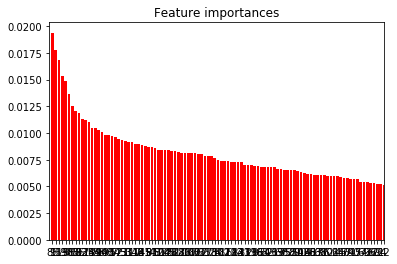

In [49]:
importance = importance / count
feature_indices = np.argsort(importance)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importance[feature_indices],
       color="r", align="center") # X_train.shape[1]
plt.xticks(range(X_train.shape[1]), feature_indices) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [50]:
name = 'Combined_Sets_from_Revised.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(feature_indices)-1):
    idx = feature_indices[i]
    print(listoffeatures[idx], importance[idx])
    if i <= 25:
        shortlist.append(listoffeatures[idx])
shortlist

Top Features listed by Importance
main83 0.019387672926019582
main93 0.01778374223839504
vix17 0.01685773613365353
main11 0.015346812738390642
main95 0.014870239878713828
main96 0.013618638989775125
main81 0.012554646522913543
main66 0.012048182867250838
main53 0.011860250077036968
main90 0.011325706746026069
invest12 0.011207913638478765
main76 0.011055409103167912
gfp3 0.010495320021033538
main97 0.010476743927044558
main56 0.010303885823032873
main88 0.010056450382568671
cci0 0.009833149059369568
main91 0.009824265075200893
main85 0.009757982732996317
main55 0.009618454015004779
gfp2 0.009475618166950188
main21 0.00934843855587798
main51 0.009279994512843108
main1 0.009153942876866387
vix15 0.0091525353741853
gfp1 0.008957760293437582
main16 0.008931041026608397
gfp4 0.00886818901799611
main39 0.008814063373650136
main6 0.00872196144354326
main89 0.008658695393824899
main46 0.00858232093291261
main48 0.008446678143336071
vix18 0.008446409470282114
invest2 0.008400228452161752
gfp0 0

['main83',
 'main93',
 'vix17',
 'main11',
 'main95',
 'main96',
 'main81',
 'main66',
 'main53',
 'main90',
 'invest12',
 'main76',
 'gfp3',
 'main97',
 'main56',
 'main88',
 'cci0',
 'main91',
 'main85',
 'main55',
 'gfp2',
 'main21',
 'main51',
 'main1',
 'vix15',
 'gfp1']

# Feature Importance

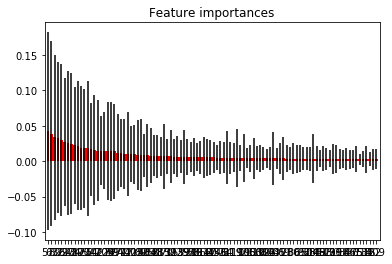

In [32]:
# Create a graph of fetaure importances

import matplotlib.pyplot as plt

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(100), importances[indices[0:100]],
       color="r", yerr=std[indices[0:100]], align="center") # X_train.shape[1]
plt.xticks(range(100), indices[0:100]) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [33]:
print(len(clf.feature_importances_))
print(len(list(train_pd)[1:]))

217
218


In [36]:
name = '../Data/Combined_Sets_from_Revised_3.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

In [37]:
# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(indices)-1):
    idx = indices[i]
    print(listoffeatures[idx], importances[idx])
#    if i <= 50:
#        shortlist.append(listoffeatures[i])

Top Features listed by Importance
main56 0.04246516422174906
main66 0.038890888318713866
main81 0.03352209371117746
main31 0.03316343824589267
main71 0.029538007701172927
main61 0.027638836562973338
main96 0.026174527778898057
main41 0.024717976602409993
main33 0.022179143584261544
main86 0.02192126337972254
google_hits40 0.018536965272188975
main26 0.018094151121507362
main51 0.017907962611983155
main53 0.01662669776174378
main46 0.015511696529390826
main6 0.015034778619333933
invest5 0.014968034625538185
google_hits53 0.014830217360014095
main28 0.01446104855036105
main36 0.013716114196511751
main48 0.01369902198463893
main93 0.012202968050008907
main76 0.011880261213021217
main73 0.010328238974565888
main16 0.010052793341765304
main19 0.009764406723616902
invest3 0.009464639641187931
main11 0.00859702479350911
main88 0.008526362192154482
main39 0.008260623177502284
main24 0.008066004010519183
main82 0.007844714248476117
gfp8 0.007815534136366665
main87 0.007041696130779015
google_hi

# SVM

In [376]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 260) #10 252 100 Draft_Google_shorter 0.8795

Last set: 6700 7110
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 7
Number of groups: 11 11


In [377]:
test = pd.DataFrame(valDataPartition[1])

In [416]:
splits = group
score_list = []
good_sets = []
gammas = []
indices = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
        #print(1 / (X_train.shape[1] * X_train.var()))
        # Fit the RF model

        #gamma =  (1 / (X_train.shape[1] * X_train.var()))
        clf = sklearn.svm.SVC(C=.7, kernel='rbf', gamma='scale') # previously 7
        clf.fit(X_train, y_train)
        
        
        # print predicitions
        pred = clf.predict(X_test)
        #print(pred)
    except:
        continue

    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
        if temp_score > 0.7:
            good_sets.append(idx)
            gammas.append(1 / (X_train.shape[1] * X_train.var()))
    except:
        pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

train: 192 339
test: 107 190
0.5106406936155837
train: 194 343
test: 137 259
train: 192 340
test: 146 259
0.5695538853194326
train: 190 336
test: 103 182
0.6136782598009094
train: 183 323
test: 141 250
0.5682217450712473
train: 227 402
test: 114 202
0.5013955342902712
train: 174 307
test: 130 259
0.5
train: 193 342
test: 83 146
0.46270797475616754
train: 200 354
test: 132 259
0.5570269625387735
train: 190 336
test: 110 195
0.5
Averaged Score is: 0.5315 11


Standard Deviation: 0.045042820127822264
[0, 2, 3, 4, 5, 6, 7, 8, 9]


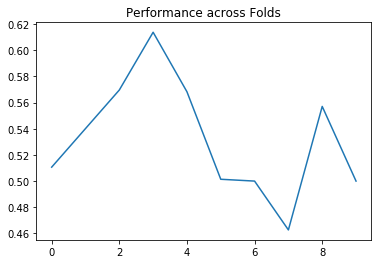

In [417]:
import matplotlib.pyplot as plt
print("Standard Deviation:", np.std(score_list))
print(indices)
plt.figure()
plt.plot(indices, score_list)
plt.title('Performance across Folds')
plt.show()

In [ ]:
good_sets

In [ ]:
pred_labels2 = []
for predlist in pred_labels:
    for x in range(len(predlist)):
        pred_labels2.append(predlist[x])
pred_labels2

# Test just one giant set
Why: Because if we can get more than 50%, we can get predictions for everything in the training set. Let's see if we can get some kind of "universal" model

In [614]:
file1 = "Combined_Sets_from_Revised_3_Label1.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
train_pd.shape

(7120, 219)

In [615]:
train_pd = train_pd[6184:]

train = np.array(train_pd)
train.shape

(936, 219)

In [683]:
valDataPartition[7]

array([[1.0, 786.5599980000001, 2.908, ..., 0.0, 0.0, 26.0],
       [1.0, 789.5, 2.891, ..., 0.0, 0.0, 26.0],
       [1.0, 783.119995, 2.944, ..., 0.0, 0.0, 26.0],
       ...,
       [1.0, 683.849976, 1.9669999999999999, ..., 1.0, 1.0, 36.0],
       [1.0, 705.049988, 1.9580000000000002, ..., 1.0, 1.0, 36.0],
       [1.0, 706.179993, 1.996, ..., 1.0, 1.0, 36.0]], dtype=object)

# Random Forest Regressor

In [156]:
def simple_time_cross(array, time_shift = 0, size_train_set = 365, size_val_set = 100, set_shift = 0):
    np.random.seed(100)
    label_idx = 0

    if time_shift == 0:
        time_shift = size_train_set + size_val_set + set_shift
        
    train_size = train.shape
    j = 0
    group = 1
    end = train_size[0]
    trainDataPartition = [] # list
    valDataPartition = []

    #print(size_train_set, size_val_set, train_size[0])
    while j + (size_train_set + size_val_set + set_shift) < train_size[0]:
        trainset = []
        valset = []

        trainset = train[j:j+size_train_set, :] # array
        valset = train[j+size_train_set+1+set_shift:j+size_train_set+size_val_set+set_shift, :]

        trainDataPartition.append(trainset)
        valDataPartition.append(valset)
    
        group = group+1;
        j = j + time_shift


    # make last set -- decide if you want to throw out or adjust this set
    print('Last set:', j, j+size_train_set)
    trainset = train[j:j+size_train_set, :]
    valset = train[j+size_train_set+1+set_shift:end, :]
    #print(trainset)
    #print(valset)
    
    trainDataPartition.append(trainset)
    valDataPartition.append(valset)

    group = len(trainDataPartition)
    group_val = len(valDataPartition)
    print('Number of groups:', group, group_val)
    
    return trainDataPartition, valDataPartition, group

In [157]:
train = np.array(train_pd)
train.shape
train = train[:, :149] # drop google columns
train

array([['1/31/91', 204.53999299999998, 1, ..., 388.5, 390.4, 395.35],
       ['2/1/91', 204.53999299999998, 1, ..., 390.4, 395.35, 398.0],
       ['2/4/91', 208.28999299999998, 1, ..., 395.35, 398.0, 403.7],
       ...,
       ['4/3/19', 1737.949951, 1, ..., 1308.4, 1299.2, 1302.65],
       ['4/4/19', 1731.209961, 1, ..., 1299.2, 1302.65, 1305.35],
       ['4/5/19', 1731.209961, 1, ..., 1302.65, 1305.35, 1308.35]],
      dtype=object)

In [158]:
labels = train[:,1]
train = train[:, 3:train.shape[1]]

In [159]:
labels = labels.reshape((7099, 1))

In [160]:
train = np.concatenate((labels, train), axis = 1)

In [211]:
[trainDataPartition, valDataPartition, group] = simple_time_cross(train, 0, 410, 260, 30)

Last set: 7000 7410
Number of groups: 11 11


In [212]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

train: 91159 410
test: 66666 259
train: 111946 410
test: 93340 259
train: 200925 410
test: 165877 259


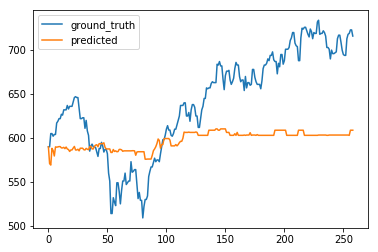

Mean Squared Error: 4422.635135135133
-0.3232456522133178
train: 312353 410
test: 164977 259


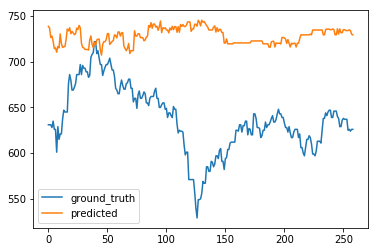

Mean Squared Error: 9920.601673101673
-6.618292927508459
train: 217488 410
test: 166536 259


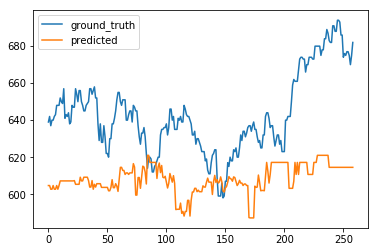

Mean Squared Error: 1605.0245602745613
-2.5755874705745563
train: 293380 410
test: 219799 259


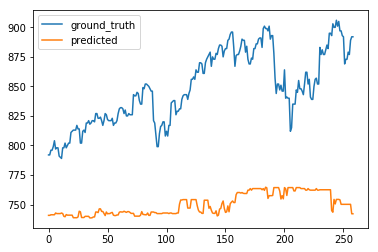

Mean Squared Error: 10458.789253539255
-9.81863110686431
train: 270980 410
test: 166918 259


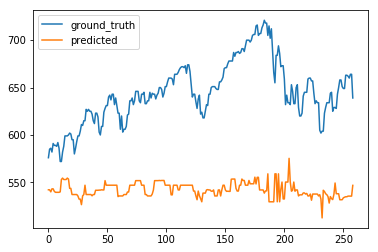

Mean Squared Error: 11486.54247104247
-9.822385114380978
train: 305055 410
test: 222032 259


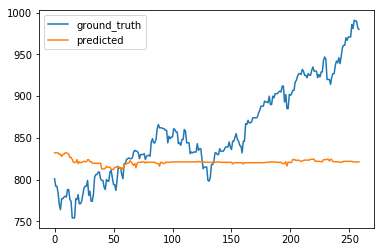

Mean Squared Error: 4488.892213642214
-0.40892822789755523
train: 452443 410
test: 313893 259


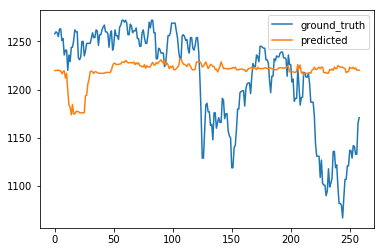

Mean Squared Error: 2992.5291720291716
-0.11012826253613928
train: 549391 410
test: 421751 259


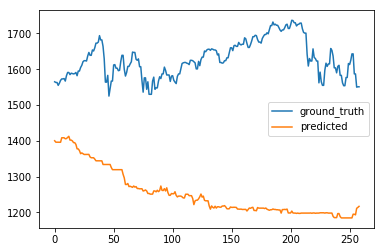

Mean Squared Error: 149890.2413127413
-54.38871658284792
Averaged Score is: -10.5082 11


In [213]:
splits = group
score_list = []
good_sets = []
gammas = []
indices = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
        #print(1 / (X_train.shape[1] * X_train.var()))
        # Fit the RF model

        #gamma =  (1 / (X_train.shape[1] * X_train.var()))
        clf = RandomForestRegressor(n_estimators=6, random_state=0) # previously 7
        clf.fit(X_train, y_train)
        
        
        # print predicitions
        pred = clf.predict(X_test)
        #print(pred)

        plt.plot(y_test, label = 'ground_truth')
        plt.plot(pred, label = 'predicted')
        plt.legend()
        plt.show()
        print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
        # add up AUROCs
    except:
        continue
            
    #try:
    SS_tot = sum((y_test - np.mean(y_test))**2)
    SS_res = sum((y_test - pred) ** 2)
    temp_score = 1 - (SS_res / SS_tot)
    score_list.append(temp_score)
    indices.append(idx)
    print(temp_score)
    if temp_score > 0.7:
        good_sets.append(idx)
        gammas.append(1 / (X_train.shape[1] * X_train.var()))
    #except:
    #    pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

A plot by itself

Mean Squared Error: 3130.7432659932665


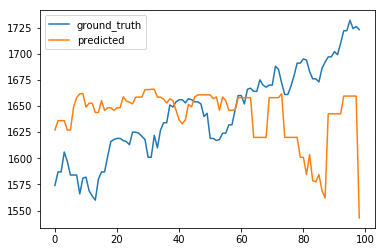

In [196]:
plt.plot(y_test, label = 'ground_truth')
plt.plot(pred, label = 'predicted')
plt.legend()
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))

In [191]:
X_test[:,95]

array([1580.73999, 1597.709961, 1617.47998, 1608.459961, 1615.689941,
       1625.420044, 1658.699951, 1653.869995, 1637.22998], dtype=object)

In [183]:
trainDataPartition[0]

array([[204.53999299999998, 176.259995, 8.02, ..., 388.5, 390.4, 395.35],
       [204.53999299999998, 173.199997, 8.13, ..., 390.4, 395.35, 398.0],
       [208.28999299999998, 172.779999, 8.16, ..., 395.35, 398.0, 403.7],
       ...,
       [235.94999700000002, 233.07000699999998, 6.76, ..., 351.15, 349.3,
        350.3],
       [235.440002, 234.36000099999998, 6.71, ..., 349.3, 350.3, 351.75],
       [234.82000699999998, 232.289993, 6.78, ..., 350.3, 351.75, 356.65]],
      dtype=object)